# Rigid wall and deformable half-circle

*Produces Figure (3)*

### Affiliations & E-mails
Flavio Lorez: [florez@ethz.ch](mailto:florez@ethz.ch)

¹: Computational Mechanics of Building Materials, ETH Zurich, Switzerland. 

### Environment setup
Special dependencies to run this notebook:
- `h5py` (and the HDF5 library)
- `mpi4py`
- `bamboost`, a python library built at CMBM for data management using HDF5.

To install `bamboost`:

```bash
git clone https://gitlab.ethz.ch/compmechmat/research/libs/bamboost.git
```

```bash
cd bamboost
pip install .
```
Alternatively to using `pip`, you can append the system path to find the package.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns

from bamboost import Manager

import utilities
utilities.set_plot_theme()

import warnings
warnings.filterwarnings('ignore')  # To disable printing of warnings

> Please specify the path to the database (The data can be found on researchcollection/eth)

In [24]:
# Enter the path to the data
database_path = '../out'

db = Manager(database_path)
db

### Compute the traction profile
We integrate the force fields $b$ in y-direction to get the traction as a function of $x$, $e.g.$
$$b(x) = \int \boldsymbol{b}\cdot \boldsymbol{e}_y ~\mathrm{dy}$$

Afterwards, we store the traction profile in the `userdata` category. In the data from researchcollection, this is already computed and available. The loop below skips any simulation if it finds the traction data in its files.

In [19]:
# Specify domain of integration
xi = np.linspace(-1, 1, 2000)
yi = np.linspace(8, 12, 2000)

# the loop checks if it was computed already
for sim in db.sims((db.df.status=='Finished') & (db.df.tag!='def-def')):
    if 'traction' in sim.userdata.keys():
        continue
    b = sim.get_data_interpolator('b', -1)
    profile = utilities.integrate_axis(b, xi, yi, 'y')
    grp = sim.userdata.require_group('traction')
    grp.add_dataset('profile', profile)
    grp.add_dataset('xi', xi)

### Select simulations from database
We conduct two parametric studies, for $\epsilon$ and for $\mathcal{M}$.

In [20]:
sims_eps = db.sims((db.df.tag=='eps study') & (db.df.status=='Finished'), sort='eps')
sims_eps_plot = db.sims((db.df.tag=='eps study') & (db.df.eps.isin((0.2, 0.6, 1.0))),
                        sort='eps', reverse=True)

sims_mob = db.sims((db.df.tag=='M study'), sort='mobility')
sims_mob_plot = db.sims((db.df.tag=='M study') & (db.df.mobility.isin((1e-2, 1e-3, 1e-6))),
                        sort='mobility', reverse=True)

### Figure

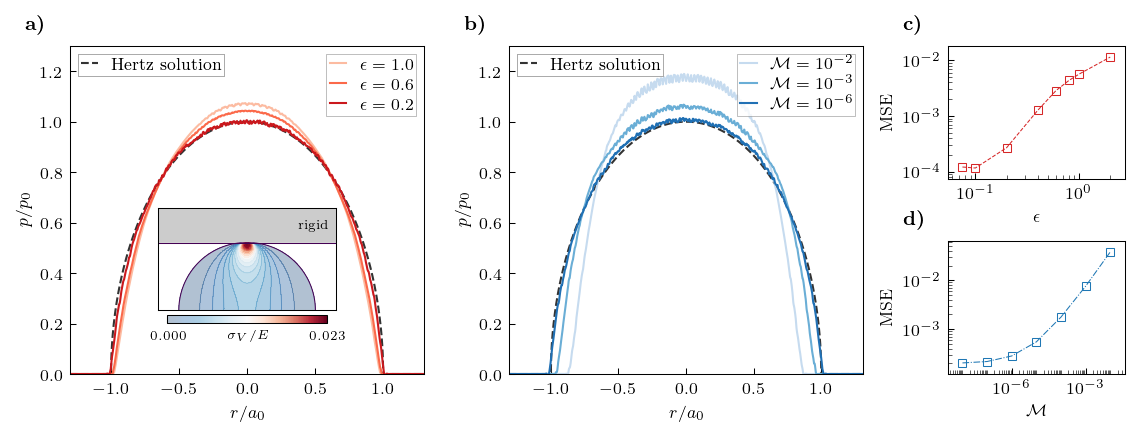

In [25]:
# -----------------------------------------------------------------------------
# FIGURE SETUP
# -----------------------------------------------------------------------------
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(7.4, 2.5))
gs = mpl.gridspec.GridSpec(2, 3, figure=fig, width_ratios=[2, 2, 1])
ax = fig.add_subplot(gs[:, 0])
bx = fig.add_subplot(gs[:, 1])
cx = fig.add_subplot(gs[0, 2])
dx = fig.add_subplot(gs[1, 2])

# -----------------------------------------------------------------------------
# FIGURE a
# -----------------------------------------------------------------------------
colors = sns.color_palette('Reds', n_colors=len(sims_eps_plot))

hertz = utilities.HertzContactJohnson(
    10, 1, sims_eps[0].globals.traction_y.to_numpy()[-1]*-1
    )

ax.plot(xi/hertz.area, hertz.contact_pressure(xi), lw=1, c='0.2', alpha=1, ls='--', label='Hertz solution')

for sim, c in zip(sims_eps_plot, colors):
    ax.plot(sim.userdata['traction/xi'][:]/hertz.area,
            -sim.userdata['traction/profile'][:, 1]/hertz.p0,
            lw=1, label=f"$\epsilon = {sim.parameters['eps']}$", c=c)

ax.set(
    xlabel='$r/a_0$',
    ylabel='$p/p_0$',
    ylim=(0, 1.3),
    xlim=(xi.min()/hertz.area, xi.max()/hertz.area),
)

# Split legend into 2
lines, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(lines[1:], labels[1:], loc='upper right')
legend2 = ax.legend([lines[0]], [labels[0]], loc='upper left')
ax.add_artist(legend1)
ax.add_artist(legend2)

# -----------------------------------------------------------------------------
# INSET
# -----------------------------------------------------------------------------
cmap = plt.cm.RdBu_r
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0.3, 1, cmap.N)
my_cmap = mpl.colors.ListedColormap(my_cmap)

# select simulation and load the data
sim = db.sims((db.df.eps==.2) & (db.df.mobility==1e-6) & (db.df.tag=='eps study'))[0]
vM = sim.data['disk_vonMises'].at_step(-1).flatten()
disk_phi = sim.data['disk_phi'].at_step(-1).flatten()
wall_phi = sim.data['wall_phi'].at_step(-1).flatten()
coords = sim.meshes['mesh'].coordinates
vonMises_range = (0, 2.3e-2)

newax = ax.inset_axes([0.5-.25, 0.15, 0.5, 0.4], zorder=1)
newax.set(xticks=[], yticks=[])
newax.tricontourf(*coords[disk_phi > .5].T,
                  vM[disk_phi > .5],
                  vmin=vonMises_range[0], vmax=vonMises_range[1],
                  cmap=my_cmap, levels=np.linspace(*vonMises_range, 20))
newax.tricontour(*coords[disk_phi>.5].T,
            vM[disk_phi>.5],
            vmin=vonMises_range[0], vmax=vonMises_range[1],
            cmap=my_cmap, levels=np.linspace(*vonMises_range, 20), linewidths=.4)

newax.axhspan(10, 15, color='0.8')
newax.text(12, 12.5, 'rigid', ha='right', va='center', fontsize=6)
newax.tricontour(coords.T[0], coords.T[1], wall_phi, levels=[.5], linewidths=.5)
newax.tricontour(coords.T[0], coords.T[1], disk_phi, levels=[.5], linewidths=.5)
newax.set_xlim(-13, 13)
newax.set_aspect('equal', 'box')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbax = inset_axes(newax, height='7.5%', width='90%', loc='lower left', bbox_to_anchor=(0.05, -.125, 1, 1), bbox_transform=newax.transAxes, borderpad=0)
cb = mpl.colorbar.ColorbarBase(cbax, cmap=my_cmap, orientation='horizontal',
                               norm=mpl.colors.Normalize(*vonMises_range), )
cb.ax.tick_params(labelsize=6)
cb.set_label('$\sigma_V/E$', size=6, labelpad=-6, )
cb.set_ticks(vonMises_range)

# -----------------------------------------------------------------------------
# FIGURE b
# -----------------------------------------------------------------------------
colors = sns.color_palette('Blues', n_colors=len(sims_mob_plot))

hertz = utilities.HertzContactJohnson(
    10, 1, sims_mob_plot[0].globals.traction_y.to_numpy()[-1]*-1
    )

bx.plot(xi/hertz.area, hertz.contact_pressure(xi), lw=1, c='0.2', alpha=1, ls='--', label='Hertz solution')

for sim, c in zip(sims_mob_plot, colors):
    bx.plot(sim.userdata['traction/xi'][:]/hertz.area,
            -sim.userdata['traction/profile'][:, 1]/hertz.p0,
            lw=1, label=f"$\mathcal{{M}} = 10^{{{int(np.log10(sim.parameters['mobility']))}}}$", c=c)

bx.set(
    xlabel='$r/a_0$',
    ylabel='$p/p_0$',
    ylim=(0, 1.3),
    xlim=(xi.min()/hertz.area, xi.max()/hertz.area),
)
lines, labels = bx.get_legend_handles_labels()
legend1 = bx.legend(lines[1:], labels[1:], loc='upper right')
legend2 = bx.legend([lines[0]], [labels[0]], loc='upper left')
bx.add_artist(legend1)
bx.add_artist(legend2)
bx.grid(False)


# -----------------------------------------------------------------------------
# FIGURE c, d
# -----------------------------------------------------------------------------
def error_func(x, y):
    """Mean squared error"""
    return (np.sum((x-y)**2)/x.size)
error_label = 'MSE'

cx.plot([s.parameters['eps'] for s in sims_eps],
        [error_func(-s['userdata/traction/profile'][:, 1] / utilities.HertzContactJohnson(10, 1, s.globals.traction_y.to_numpy()[-1]*-1).p0,
                    utilities.HertzContactJohnson(10,1,s.globals.traction_y.to_numpy()[-1]*-1).contact_pressure(xi, normalize=True)) for s in sims_eps],
        marker='s', ls='--', c='tab:red', markersize=4, mfc='None')
cx.margins(.1)
cx.set(
    yscale='log',
    xscale='log',
    xlabel='$\epsilon$',
    ylabel=error_label,
    )
cx.grid(False)

dx.plot([s.parameters['mobility'] for s in sims_mob],
        [error_func(-s['userdata/traction/profile'][:, 1] / utilities.HertzContactJohnson(10, 1, s.globals.traction_y[5]*-1).p0,
                    utilities.HertzContactJohnson(10, 1, s.globals.traction_y[5]*-1).contact_pressure(xi, normalize=True)) for s in sims_mob],
        marker='s', ls='-.', c='tab:blue', markersize=4, mfc='None')
dx.set_xscale('log')
dx.set_yscale('log')
dx.margins(.1)
dx.set(
    ylim=(None, None),
    xlabel='$\mathcal{M}$',
    ylabel=error_label,
)
dx.grid(False)


locmin = mpl.ticker.LogLocator(base=10.0, subs=(
    0.1, .2, .3, .4, .5, .6, .7, .8, .9), numticks=12)
dx.xaxis.set_minor_locator(locmin)
dx.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# -----------------------------------------------------------------------------
plt.tight_layout(h_pad=1, w_pad=1, pad=0)

# Add subplot labels
utilities.subplot_label(ax, 'a')
utilities.subplot_label(bx, 'b')
utilities.subplot_label(cx, 'c')
utilities.subplot_label(dx, 'd')

fig.savefig('figs/figure_hertz_rigid.pdf', dpi=1000, bbox_inches='tight', pad_inches=.01)